In [ ]:
#Importing Libraries
import pandas as pd
import numpy as np

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import MinMaxScaler

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#reading Dataset
retail = pd.read_csv("/content/drive/MyDrive/OnlineRetail.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)
#if you dont use encoding option , you will get the following error ""UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa3 in position 28: invalid start byte""
# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d-%m-%Y %H:%M")

In [ ]:
# Let's look top 5 rows
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
#Sanity Check
retail.shape
retail.describe()
retail.info()
retail.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


(541909, 8)

In [ ]:
#na handling
retail.isnull().values.any()
retail.isnull().values.sum()
retail.isnull().sum()*100/retail.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [ ]:
#dropping the na cells
order_wise = retail.dropna()

In [ ]:
#Sanity check
order_wise.shape
order_wise.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
#RFM implementation

# Extracting amount by multiplying quantity and unit price and saving the data into amount variable.
amount  = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns = ["Amount"])
amount.head()

,Amount
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


In [ ]:
#merging amount in order_wise
order_wise = pd.concat(objs = [order_wise, amount], axis = 1, ignore_index = False)

#Monetary Function
# Finding total amount spent per customer
monetary = order_wise.groupby("CustomerID").Amount.sum()
monetary = monetary.reset_index()
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
#Frequency function
frequency = order_wise[['CustomerID', 'InvoiceNo']]

In [ ]:
# Getting the count of orders made by each customer based on customer ID.
k = frequency.groupby("CustomerID").InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ["CustomerID", "Frequency"]
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [ ]:
#creating master dataset
master = monetary.merge(k, on = "CustomerID", how = "inner")
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [ ]:
recency  = order_wise[['CustomerID','InvoiceDate']]
maximum = max(recency.InvoiceDate)

In [ ]:
#Generating recency function

# Filtering data for customerid and invoice_date
recency  = order_wise[['CustomerID','InvoiceDate']]

# Finding max data
maximum = max(recency.InvoiceDate)

# Adding one more day to the max data, so that the max date will have 1 as the difference and not zero.
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate
recency.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


In [ ]:
# recency by customerid
a = recency.groupby('CustomerID')

In [ ]:
a['diff'].min()

CustomerID
12346.0   326 days 02:33:00
12347.0     2 days 20:58:00
12348.0    75 days 23:37:00
12349.0    19 days 02:59:00
12350.0   310 days 20:49:00
                 ...       
18280.0   278 days 02:58:00
18281.0   181 days 01:57:00
18282.0     8 days 01:07:00
18283.0     4 days 00:48:00
18287.0    43 days 03:21:00
Name: diff, Length: 4372, dtype: timedelta64[ns]

In [ ]:
#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID')['diff'].min())
df = df.reset_index()
df.columns = ["CustomerID", "Recency"]
df.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


In [ ]:
#Combining all recency, frequency and monetary parameters
RFM = k.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df, on = "CustomerID")
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00


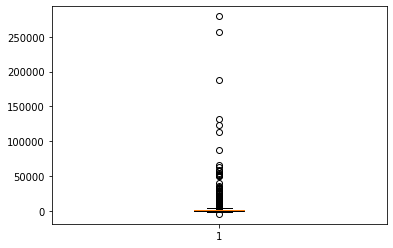

In [ ]:
# outlier treatment for Amount
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= (Q1 - 1.5*IQR)) & (RFM.Amount <= (Q3 + 1.5*IQR))]

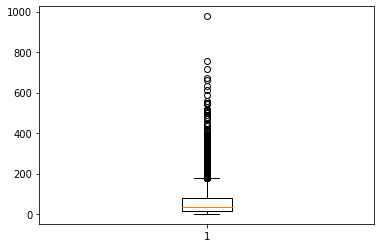

In [ ]:
# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

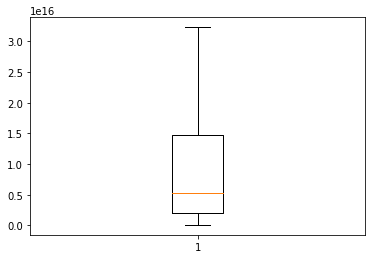

In [ ]:
# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]


In [ ]:
RFM.head(20)

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00
6,12353.0,4,89.00,204 days 19:03:00
7,12354.0,58,1079.40,232 days 23:39:00
8,12355.0,13,459.40,214 days 23:01:00
9,12356.0,59,2811.43,23 days 04:10:00
11,12358.0,19,1168.06,2 days 02:24:00


In [ ]:
RFM_norm1 = RFM.drop(["CustomerID"], axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

sc = MinMaxScaler((0, 1))
df = sc.fit_transform(RFM_norm1)


In [ ]:
# a random number of cluster is being given as a parameter

kmeans = KMeans(n_clusters=4)
k_fit = kmeans.fit(df)

In [ ]:
# centeroids for the 4 clusters

dd=k_fit.cluster_centers_
k_fit.cluster_centers_

array([[0.11368295, 0.39424446, 0.15716036],
       [0.72710117, 0.69270572, 0.10819491],
       [0.11916595, 0.37873587, 0.69924236],
       [0.37651056, 0.51611437, 0.11346467]])

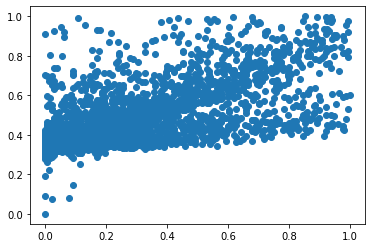

In [ ]:
plt.scatter(df[:,0], df[:,1])

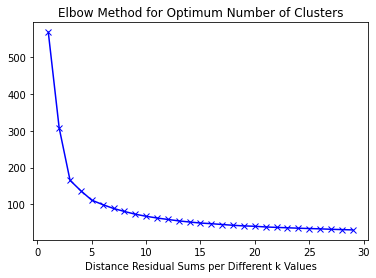

In [ ]:
import matplotlib.pyplot as plt
# number of clusters between range(1,30) will be given as parameters within KMeans object

kmeans = KMeans()
ssd = []
K = range(1, 30)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(df)
    ssd.append(kmeans.inertia_)
    
plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums per Different k Values")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

In [ ]:
!pip install yellowbrick

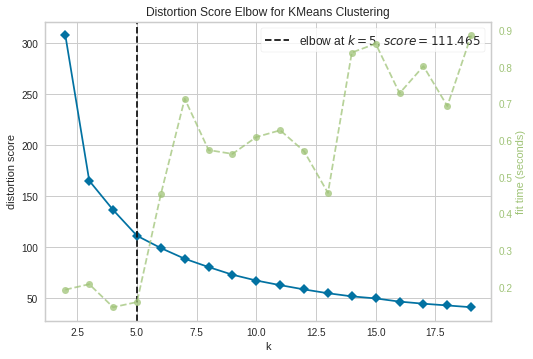

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k=(2, 20))
visu.fit(df)
visu.show()

In [ ]:
kmeans = KMeans(n_clusters= 5, init= 'k-means++', max_iter= 1000)
kmeans.fit(df)
clusters = kmeans.labels_

In [ ]:
# segment labels for the first 30 customers

clusters[0:30]

array([4, 0, 0, 4, 0, 1, 1, 1, 0, 3, 2, 4, 3, 0, 4, 3, 2, 0, 0, 4, 3, 3,
       4, 3, 2, 0, 2, 3, 4, 2], dtype=int32)

In [ ]:
# customer id's and the segment numbers

pd.DataFrame({"Customer ID": RFM.index, "Clusters": clusters})
RFM["Cluster"] = clusters
RFM["Cluster"] = RFM["Cluster"] + 1

,Customer ID,Clusters
0,0,4
1,2,0
2,3,0
3,4,4
4,5,0
...,...,...
3692,4366,3
3693,4367,4
3694,4368,1
3695,4369,3


In [ ]:
RFM.head(15)

,CustomerID,Frequency,Amount,Recency,Cluster
0,12346.0,2,0.00,326 days 02:33:00,5
2,12348.0,31,1797.24,75 days 23:37:00,1
3,12349.0,73,1757.55,19 days 02:59:00,1
4,12350.0,17,334.40,310 days 20:49:00,5
5,12352.0,95,1545.41,36 days 22:13:00,1
6,12353.0,4,89.00,204 days 19:03:00,2
7,12354.0,58,1079.40,232 days 23:39:00,2
8,12355.0,13,459.40,214 days 23:01:00,2
9,12356.0,59,2811.43,23 days 04:10:00,1
11,12358.0,19,1168.06,2 days 02:24:00,4


Text(0.5, 0, 'Recency')

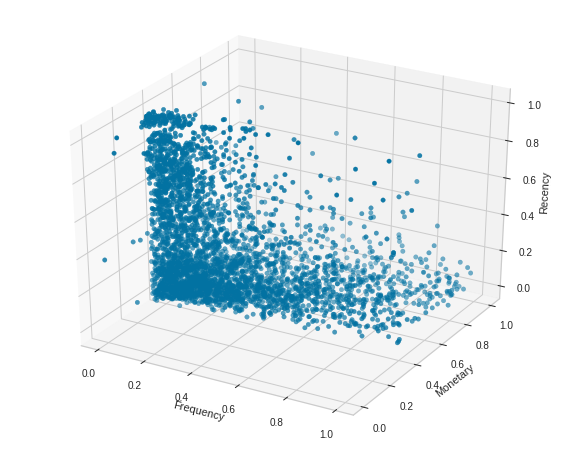

In [ ]:
plt.figure(figsize=(10,8))
ax= plt.axes(projection= '3d')


fg = ax.scatter3D(df[:,0], df[:,1],df[:,2], s= 20)
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Recency')


In [ ]:
meme = pd.DataFrame()
meme ["r"] = df[:,0]
meme ["f"] = df[:,1]
meme ["m"] = df[:,2]
meme ["cluster"] = clusters
meme

In [ ]:
meme.loc[meme['cluster'] == 0, 'color'] = 'yellow'
meme.loc[meme['cluster'] == 1, 'color'] = 'purple'
meme.loc[meme['cluster'] == 2, 'color'] = 'limegreen'
meme.loc[meme['cluster'] == 3, 'color'] = 'red'
meme.loc[meme['cluster'] == 4, 'color'] = 'blue'
meme

,r,f,m,cluster,color
0,0.005650,0.308841,0.871314,4,blue
1,0.169492,0.657391,0.198391,0,yellow
2,0.406780,0.649693,0.048257,0,yellow
3,0.090395,0.373693,0.828418,4,blue
4,0.531073,0.608552,0.093834,0,yellow
...,...,...,...,...,...
3692,0.045198,0.342567,0.195710,3,red
3693,0.050847,0.343866,0.742627,4,blue
3694,0.033898,0.324515,0.482574,1,purple
3695,0.067797,0.343090,0.018767,3,red


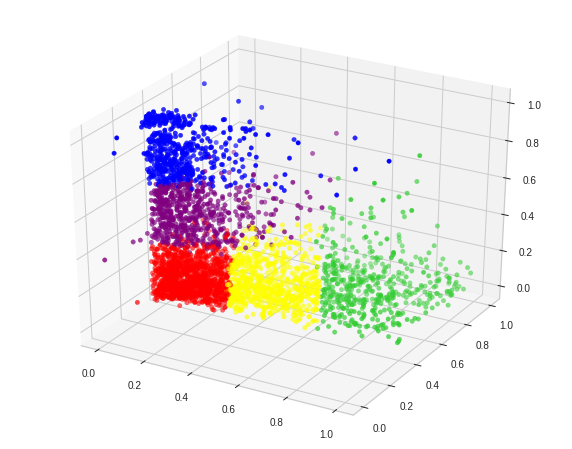

In [ ]:
plt.figure(figsize=(10,8))
ax= plt.axes(projection= '3d')
fg = ax.scatter3D(meme["r"], meme["f"],meme["m"], s= 20, c= meme["color"])